In [31]:
import pandas as pd # for data manipulation
print('pandas: %s' % pd.__version__) # print version
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version
import math # to help with data reshaping of the data

import numpy as np
import torch
#import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from sklearn.model_selection import train_test_split
import tqdm
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pandas: 1.4.1
numpy: 1.21.5


In [2]:
df=pd.read_csv('weatherAUS.csv', encoding='utf-8')

# Drop records where target MinTemp=NaN or MaxTemp=NaN
df=df[pd.isnull(df['MinTemp'])==False]
df=df[pd.isnull(df['MaxTemp'])==False]

df['MedTemp']=df[['MinTemp', 'MaxTemp']].median(axis=1)

df2 = df.loc[df.Location=='Canberra'].loc[:, ['Date', 'MedTemp']]
df2.head()

,Date,MedTemp
45587,2007-11-01,16.15
45588,2007-11-02,20.45
45589,2007-11-03,18.55
45590,2007-11-04,14.40
45591,2007-11-05,11.85


In [3]:
def prep_data(datain, time_step):
    # 1. y-array  
    # First, create an array with indices for y elements based on the chosen time_step
    y_indices = np.arange(start=time_step, stop=len(datain), step=time_step)
    # Create y array based on the above indices 
    y_tmp = datain[y_indices]
    
    # 2. X-array  
    # We want to have the same number of rows for X as we do for y
    rows_X = len(y_tmp)
    # Since the last element in y_tmp may not be the last element of the datain, 
    # let's ensure that X array stops with the last y
    X_tmp = datain[range(time_step*rows_X)]
    # Now take this array and reshape it into the desired shape
    X_tmp = np.reshape(X_tmp, (rows_X, time_step, 1))
    return X_tmp, y_tmp

datain = np.array(df2.MedTemp)
X, Y = prep_data(datain, 7)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [4]:
X_train.shape
Y_train.shape
X_test.shape

(391, 7, 1)

(391,)

(98, 7, 1)

In [85]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        # self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        # output = self.softmax(output)
        return output, hidden

    def initHidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size).requires_grad_()

# model = nn.Sequential()
#model.add_module(nn.Linear(in_features=7, ))
# model.add_module("rnn", module=RNN(input_size=1, hidden_size=10, output_size=1))



In [14]:
X_train.shape
X_train[:, 2, :].reshape(-1,1).shape



(391, 7, 1)

(391, 1)

In [15]:
criterion = nn.MSELoss()
hidden = torch.zeros(X_train.shape[0], 10).requires_grad_()
bs = 10
for i in range(X_train.shape[1]):
    indata = X_train[:, i, :].reshape(-1, 1)
    output, hidden = rnn(torch.tensor(indata).float(), hidden)

loss = criterion(output.reshape(-1), torch.tensor(Y_train).float())
loss.backward()
# for p in rnn.parameters():
#         p.data.add_(p.grad.data, alpha=-learning_rate)

In [84]:
foo = nn.RNN(10, 20, 2)
input = torch.randn(7, 3, 10)  # 7 is the length of TS. 3 is batch size. 10 is actual input size
h0 = torch.randn(2, 3, 20)  # 2 is for number of stacked RNNs. 3 is batch size. 20 is hidden size.
output, hn = foo(input, h0)
foo.batch_first

False

In [71]:
params = list(rnn.parameters())
for param in params:
    print(param.shape)

torch.Size([10, 11])
torch.Size([10])
torch.Size([1, 11])
torch.Size([1])


In [73]:
params

[Parameter containing:
 tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
        requires_grad=True),
 Parameter containing:
 tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], requires_grad=True),
 Parameter containing:
 tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
        requires_grad=True),
 Parameter containing:
 tensor([nan], requires_grad=True)]

In [23]:
# for p in rnn.parameters():
#         p.data.add_(p.grad.data, alpha=-learning_rate)
params[-2].grad.data

tensor([[-329.8080,   -4.4984,  -79.2671,   46.8329,  -24.2118,   64.6137,
          103.4636,   -9.8516,   -8.5276,  -34.1214,  -29.6031]])

In [88]:
criterion = nn.MSELoss()
learning_rate=0.00001
losses = []

rnn = RNN(input_size=1, hidden_size=10, output_size=1)

n_iter = 150

for i in tqdm.tqdm(range(n_iter)):
    hidden = torch.zeros(X_train.shape[0], 10).requires_grad_()
    bs = 10
    for i in range(X_train.shape[1]):
        indata = X_train[:, i, :].reshape(-1, 1)
        output, hidden = rnn(torch.tensor(indata).float(), hidden)

    loss = criterion(output.reshape(-1), torch.tensor(Y_train).float())
    loss.backward()
    for p in rnn.parameters():
            _ = p.data.add_(p.grad.data, alpha=-learning_rate)

    losses.append(loss.item())

100%|██████████| 150/150 [00:00<00:00, 297.12it/s]


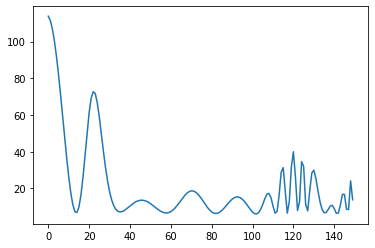

In [89]:
plt.plot(losses[:210])

In [63]:
losses[:5]

[229.00157165527344,
 225.6512908935547,
 219.05035400390625,
 209.3943634033203,
 196.96795654296875]

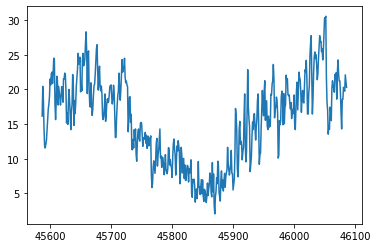

In [35]:
plt.plot(df2.MedTemp[:500])

In [92]:
xin = df2.MedTemp[:7].array
def predict(xin):
    hidden = rnn.initHidden(batch_size=1)
    for x in xin:
        out, hidden = rnn(torch.tensor(x).float().reshape((1, 1)), hidden)
    yout = out.detach().numpy()
    return yout




<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

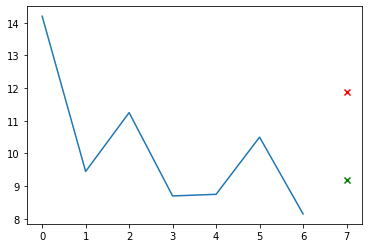

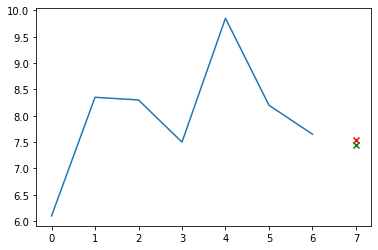

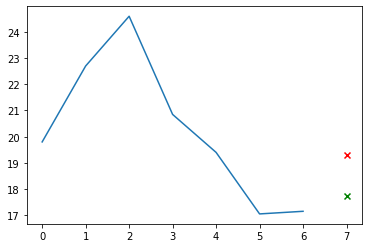

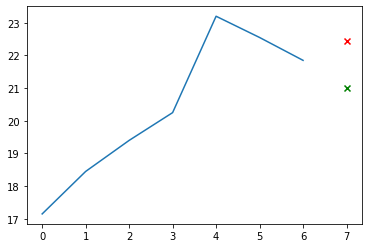

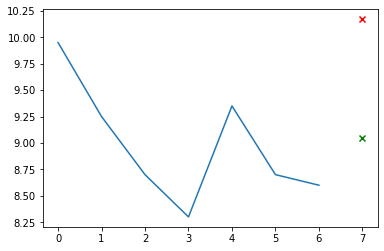

In [93]:
def plot(xin, ypred, ytrue):
    plt.plot(xin)
    plt.scatter(len(xin), ypred, color='r', marker='x')
    plt.scatter(len(xin), ytrue, color='g', marker='x')


for i in range(10, 15):
    xin = X_test[i]
    ypred = predict(xin)
    ytrue = Y_test[i]
    plt.figure()
    plot(xin, ypred, ytrue)


In [50]:
xin

<PandasArray>
[             16.15,              20.45, 18.549999999999997,
               14.4, 11.850000000000001, 11.549999999999999,
 12.149999999999999]
Length: 7, dtype: float64

In [ ]:
3